This notebook can be used to train diffusion model. All the running script is included in this file.

In [1]:
# %%capture
# !pip install torch torchvision
# !pip install omegaconf pytorch_lightning
# !pip install -q -U einops datasets tqdm
# !pip install matplotlib==3.1.3
# !pip install wandb
# !pip install -U scikit-image
# !pip install evalutils==0.3.1
# !pip install SimpleITK==2.0.2
# !pip install scikit-learn==0.24.2
# !pip install scipy==1.6.3
# !pip install python-dotenv==1.0.0

In [3]:
# %%capture
# !pip install h5py
# !pip install tifffile

In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
CURR_DIR = os.path.dirname('__file__')
ROOT_DIR=os.path.join(os.getcwd() ,'..')
sys.path.append(ROOT_DIR)

from omegaconf import OmegaConf
#load configs
config = OmegaConf.load(os.path.join(ROOT_DIR,'run_scripts/configs/ddpm-cond/exp01_brain_1BA001_ct_config.yaml'))

### use the below code to generate hdf5 files from *.nii.gz files

In [2]:
#--> HDF5 files for 1BA001 sample is already created. <--#

# from utils.create_training_images import save_as_hdf5, create_folder
# PATH = "/dss/dsshome1/0D/ge59suz2/thesis/code/dm4mi/vanilla-dm4mi/" # path to your code
# mr_path = PATH + "run_scripts/data/brain/1BA001/mr.nii.gz"
# ct_path = PATH + "run_scripts/data/brain/1BA001/ct.nii.gz"
# image_size = config.model.params.image_size
# batch_size = config.model.params.batch_size
# stride = 32

# target_direc_mr = PATH + "run_scripts/data/brain/1BA001/mr_h5files_"+str(image_size)+"x"+str(image_size)+"_bs_"+str(batch_size)+"_s_"+str(stride) # hdf5 files will be saved here.
# target_direc_ct = PATH + "run_scripts/data/brain/1BA001/ct_h5files_"+str(image_size)+"x"+str(image_size)+"_bs_"+str(batch_size)+"_s_"+str(stride) # hdf5 files will be saved here.
# '''
# Parameters
# -------
# :image_size: output size of the volumes
# :stride: at what interval to cut the volume
# '''
# save_as_hdf5(inputpath=mr_path, datasetname="mr", targetdir=target_direc_mr, image_size=image_size, stride=stride)
# save_as_hdf5(inputpath=ct_path, datasetname="ct", targetdir=target_direc_ct, image_size=image_size, stride=stride)

In [ ]:
import wandb
# !wandb login

### Import DDPM class

In [2]:
from utils.initialize_configs import instantiate_from_configs
ddpmModel = instantiate_from_configs(config.model)
datasetName = 'brain_ct_1BA001' # prefix used for saving checkpoints.
gpu_version = '193899_run0' # prefix used for saving checkpoints.

2023-06-20 12:31:33.704200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-20 12:31:33.706324: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
%%capture
ddpmModel.cuda()

In [4]:
for batch in ddpmModel.train_dataloader():
    print(batch["x_cond"].size())
    break

torch.Size([1, 1, 64, 64, 64])


In [6]:
for key in batch.keys():
    print(key)

x_cond
x_prior


In [6]:
def show_images(dataset, num_samples=24, cols=4, random=True, save_all=False, filename="abc.png"):
    """ Plot400s some samples from the dataset """
    random_img_idx = np.random.randint(0, high=len(dataset), size=len(dataset), dtype=int)
    rows = int(num_samples//cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14,14))    
    img_count=0
    for i in range(rows):
        for j in range(cols):
            random_index = random_img_idx[i*cols + j] if random else img_count#int(np.random.random()*len(dataset))
            img = dataset[0][random_index] # use for stanford_Cars
            out = img.numpy() #.reshape(ddpmModel.image_size, ddpmModel.image_size)
            axes[i, j].imshow(out, cmap='Greys')    
            img_count = img_count + 1    
    if save_all:
        assert filename is not None, "Filename missing.."
        plt.savefig(filename)

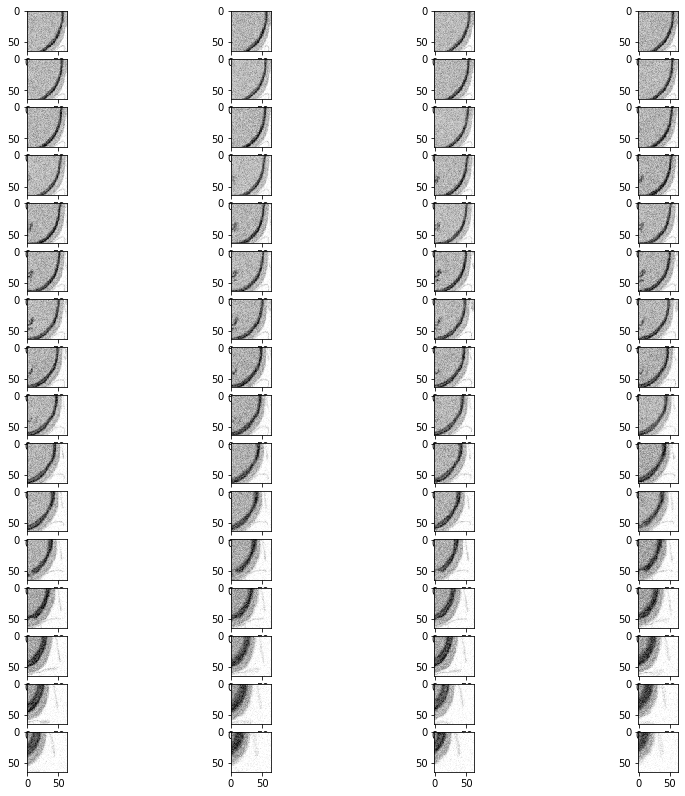

In [7]:
# plot training datset
show_images(dataset=ddpmModel.noisy_dataset[0], num_samples=64, cols=4, random=False, save_all=False, filename="SC_trainset") 

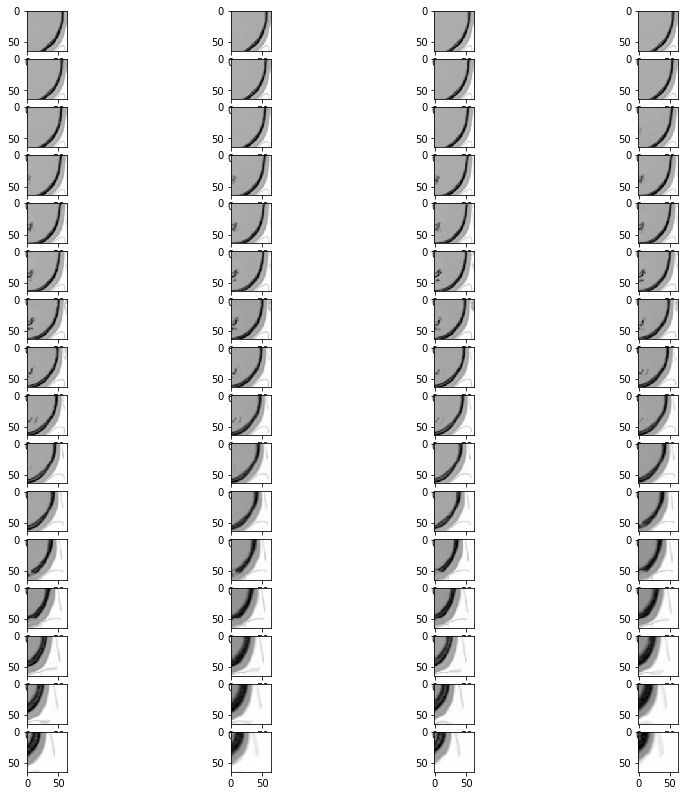

In [8]:
show_images(dataset=ddpmModel.train_dataset[0], num_samples=64, cols=4, random=False, save_all=False, filename="SC_trainset") 

In [ ]:
%%capture
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar, Timer, ModelCheckpoint
import time
from pytorch_lightning.loggers import WandbLogger

# stop training after 12 hours
timer = Timer(duration="00:12:00:00")

# or provide a datetime.timedelta
from datetime import timedelta
timer = Timer(duration=timedelta(weeks=1))
timestr = time.strftime("%d%m%y-%H%M%S")
loss_type = ddpmModel.loss_type
alpha = ddpmModel.learning_rate
task = 'cond-ddpm'

CKPT_DIR = 'folderpath'+datasetName # Replace
CKPT_DIR = CKPT_DIR + '/'+gpu_version+'/checkpoints'
checkpoint = ModelCheckpoint(
    save_top_k=2,
    monitor="val/loss_simple",    
    filename=timestr + "-{epoch}-{step}-" + "-loss=%s"%loss_type + "-a=%.1E"%alpha + '-' + datasetName
)
trainer = Trainer(max_steps=ddpmModel.max_tsteps, accelerator="gpu", devices=-1, callbacks=[TQDMProgressBar(refresh_rate=10), timer, checkpoint]) # To use all available GPUs put -1 or '-1'
# for running the code on cpu, uncomment below line
#  trainer = Trainer(max_steps=ddpmModel.max_tsteps, callbacks=[TQDMProgressBar(refresh_rate=10), timer, checkpoint]) # To use all available GPUs put -1 or '-1'


In [ ]:
trainer.fit(ddpmModel)

# query training/validation/test time (in seconds)
print("Total training time: %.2f mins" % (timer.time_elapsed("train")/60))

# save last checkpoint
timestr = time.strftime("%d%m%y-%H%M%S")
train_loss = "{:.4f}".format(trainer.logged_metrics['train/loss_simple'].item())
CKPT_NAME = timestr + "_"+datasetName + "_lastckpt_tloss_" + str(train_loss) + ".ckpt"
logger_version = "version_"+str(trainer.logger.version)
PATH = "lightning_logs/" + logger_version+ "/checkpoints/"+CKPT_NAME
trainer.save_checkpoint(PATH)

## DDPM Sampling

In [ ]:
ddpmModel.cuda()
ddpmModel.clip_denoised = False
ddpmModel.log_every_t = 100
num_samples = 24 # samples 5 images
samples = ddpmModel.sample(batch_size=num_samples)

## Save as tiff

In [15]:
from utils.fileio import save_as_tiff

In [18]:
for gt_images in ddpmModel.train_dataloader():
    break

In [25]:
gt_images.min()

tensor(-0.9922)

In [21]:
save_as_tiff(samples, "samples_"+gpu_version+".tiff")
save_as_tiff(gt_images.reshape(64,1,64,64), "ground_truth_"+gpu_version+".tiff")

In [26]:
samples_clamped = samples.clamp_(-1,1)

In [31]:
gt_images.shape

torch.Size([1, 1, 64, 64, 64])

## Calculate metrics

In [32]:
from metrics.image_metrics import ImageMetrics

mask = None #np.ones(samples.shape)

metrics = ImageMetrics()
dynamic_range = 1 - -1

print(metrics.image_scores(gt_images.reshape(64,1,64,64)[:24].cpu().numpy(), samples_clamped.cpu().numpy(), mask, dynamic_range))

{'mae': 0.47716110055335204, 'ssim': 0.010848510079085827, 'psnr': 10.147042396683037}


## DDIM Sampling

In [ ]:
from models.ddim import DDIM
sampler = DDIM(ddpmModel)
# total sampled images: batch_size==128
ddim_steps = 200
ddim_eta = 0.995
scale = 3.0 
num_of_samples = 200
use_DDPM_sampling = False
samples_ddim, intermediate_samples = sampler.sample(S=ddim_steps,
                                    batch_size=num_of_samples,
                                    shape=[ddpmModel.channels, ddpmModel.image_size, ddpmModel.image_size],
                                    use_ddpm_sampling=use_DDPM_sampling,
                                    verbose=False,
                                    log_every_t=1,
                                    eta=ddim_eta)

In [34]:
samples_ddim.shape

torch.Size([200, 1, 64, 64])

In [35]:
images = []
for batch in ddpmModel.train_dataloader():
    if len(images)<10:
        images.append(batch.reshape(64,1,64,64))

In [36]:
images_stacked = np.stack(images)

In [37]:
i = images_stacked.reshape(640,1,64,64)

In [38]:
type(samples_ddim)

torch.Tensor

In [39]:
print(metrics.image_scores(i[:200], samples_ddim.cpu().numpy(), mask, dynamic_range))

{'mae': 0.46073035626084413, 'ssim': 0.02352358028292656, 'psnr': 10.559639046598788}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
cols=4
rows=rows=int(num_samples // cols)
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14,14))
for i in range(rows):
    for j in range(cols):        
        axes[i, j].imshow(samples_ddim[img_count].cpu().numpy().reshape(ddpmModel.image_size, ddpmModel.image_size), cmap='Greys') #use this statement for cifar10
        img_count+=1
# plt.savefig("185950_run3_sampled_images.png")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
cols=4
rows=rows=int(num_samples // cols)
img_count = 30

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14,14))
for i in range(rows):
    for j in range(cols):        
        axes[i, j].imshow(gt_images[0,0][img_count].cpu().numpy().reshape(ddpmModel.image_size, ddpmModel.image_size), cmap='Greys') #use this statement for cifar10
        img_count+=1

In [ ]:
import torch
x1 = gt_images[0,0][30].reshape(1,64,64).to(device='cuda')
x2 = gt_images[0,0][54].reshape(1,64,64).to(device='cuda')
t = torch.randint(0, 100, (2,), device=ddpmModel.device).long()
interploted_img = ddpmModel.interpolate(x1,x2,t)